In [ ]:
import json
import os
import numpy as np
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras import layers
from keras.regularizers import l2

In [ ]:
train_data = []
trainset_path = './train/'
for file in os.listdir(trainset_path):
    if '.json' not in file:
        continue
    if file == 'schema.json':
        continue
        
    with open(os.path.join(trainset_path, file), 'r') as json_file:
        for elem in json.load(json_file):
            train_data.append(elem)

In [ ]:
test_data = []
testset_path = './test/'
for file in os.listdir(testset_path):
    if '.json' not in file:
        continue
    if file == 'schema.json':
        continue
        
    with open(os.path.join(testset_path, file), 'r') as json_file:
        for elem in json.load(json_file):
            test_data.append(elem)

In [ ]:
train_intents = []
test_intents = []
train_sentences = []
test_sentences = []

misc_train_sentences = []
misc_train_intents = []
misc_test_sentences = []
misc_test_intents = []

none_train_sentences = []
none_train_intents = []
none_test_sentences = []
none_test_intents = []

for dialogue in train_data:
    for idx in range(0, len(dialogue['turns']), 2):
        sentence = dialogue['turns'][idx]['utterance']
        intent = dialogue['turns'][idx]['frames'][0]['state']['active_intent']
        if intent not in ['FindRestaurants', 'ReserveRestaurant', 'NONE']:
          misc_train_sentences.append(sentence)
          misc_train_intents.append(3)
        else:
          if intent == 'FindRestaurants':
            train_sentences.append(sentence)
            train_intents.append(0)
          elif intent == 'ReserveRestaurant':
            train_sentences.append(sentence)
            train_intents.append(1)
          else:
            none_train_sentences.append(sentence)
            none_train_intents.append(2)
        
for dialogue in test_data:
    for idx in range(0, len(dialogue['turns']), 2):
        sentence = dialogue['turns'][idx]['utterance']
        intent = dialogue['turns'][idx]['frames'][0]['state']['active_intent']
        if intent not in ['FindRestaurants', 'ReserveRestaurant', 'NONE']:
          misc_test_sentences.append(sentence)
          misc_test_intents.append(3)
        else:
          if intent == 'FindRestaurants':
            test_sentences.append(sentence)
            test_intents.append(0)
          elif intent == 'ReserveRestaurant':
            test_sentences.append(sentence)
            test_intents.append(1)
          else:
            none_test_sentences.append(sentence)
            none_test_intents.append(2)

misc_train = [ (x, y) for x, y in zip(misc_train_sentences, misc_train_intents) ]
random.shuffle(misc_train)
misc_test = [ (x, y) for x, y in zip(misc_test_sentences, misc_test_intents) ]
random.shuffle(misc_test)

none_train = [ (x, y) for x, y in zip(none_train_sentences, none_train_intents) ]
random.shuffle(none_train)
none_test = [ (x, y) for x, y in zip(none_test_sentences, none_test_intents) ]
random.shuffle(none_test)

train_intents.extend([y for _, y in none_train][0:len(train_intents)//2])
test_intents.extend([y for _, y in none_test][0:len(test_intents)//2])
train_sentences.extend([x for x, _ in none_train][0:len(train_sentences)//2])
test_sentences.extend([x for x, _ in none_test][0:len(test_sentences)//2])

train_intents.extend([y for _, y in misc_train][0:len(train_intents)//3])
test_intents.extend([y for _, y in misc_test][0:len(test_intents)//3])
train_sentences.extend([x for x, _ in misc_train][0:len(train_sentences)//3])
test_sentences.extend([x for x, _ in misc_test][0:len(test_sentences)//3])

In [ ]:
train_sentences = np.array(train_sentences)
test_sentences = np.array(test_sentences)
train_intents = np.array(train_intents)
test_intents = np.array(test_intents)

In [ ]:
print(dict(zip(*np.unique(train_intents, return_counts=True))))
print(dict(zip(*np.unique(test_intents, return_counts=True))))

{0: 6668, 1: 8450, 2: 7559, 3: 7559}
{0: 1366, 1: 1754, 2: 1560, 3: 1560}


In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(np.array(train_sentences))

In [ ]:
train_sentences[0]

"Some Barbecue would work well. Just make sure that it's reasonably priced."

In [ ]:
n_class = 4
encoded_train = tf.keras.utils.to_categorical(train_intents, n_class)
encoded_test = tf.keras.utils.to_categorical(test_intents, n_class)

# Create the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),#, return_sequences=True
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(n_class, activation="softmax")])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_sentences, y=encoded_train, epochs=10,
                    validation_data=(test_sentences, encoded_test),
                    validation_steps=30, batch_size=64, shuffle=True)

Epoch 1/10
473/473 [==============================] - 14s 17ms/step - loss: 1.1095 - accuracy: 0.5577 - val_loss: 1.0669 - val_accuracy: 0.5719
Epoch 2/10
473/473 [==============================] - 6s 14ms/step - loss: 0.6807 - accuracy: 0.7523 - val_loss: 0.9195 - val_accuracy: 0.7016
Epoch 3/10
473/473 [==============================] - 6s 13ms/step - loss: 0.5704 - accuracy: 0.7915 - val_loss: 0.8471 - val_accuracy: 0.7359
Epoch 4/10
473/473 [==============================] - 6s 13ms/step - loss: 0.5170 - accuracy: 0.8078 - val_loss: 0.8024 - val_accuracy: 0.7453
Epoch 5/10
473/473 [==============================] - 6s 13ms/step - loss: 0.4837 - accuracy: 0.8154 - val_loss: 0.8032 - val_accuracy: 0.7521
Epoch 6/10
473/473 [==============================] - 6s 13ms/step - loss: 0.4604 - accuracy: 0.8201 - val_loss: 0.7914 - val_accuracy: 0.7630
Epoch 7/10
473/473 [==============================] - 6s 13ms/step - loss: 0.4428 - accuracy: 0.8244 - val_loss: 0.7613 - val_accuracy: 0.769

In [ ]:
test_loss, test_acc = model.evaluate(x=test_sentences, y=encoded_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

195/195 [==============================] - 3s 6ms/step - loss: 0.6251 - accuracy: 0.7888
Test Loss: 0.6250861287117004
Test Accuracy: 0.7887820601463318


In [ ]:
y_pred = model.predict(test_sentences)
matrix = confusion_matrix(encoded_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1043  127   15  181]
 [ 125 1367   52  210]
 [  12   48 1477   23]
 [ 185  300   40 1035]]


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.1446374773979187)

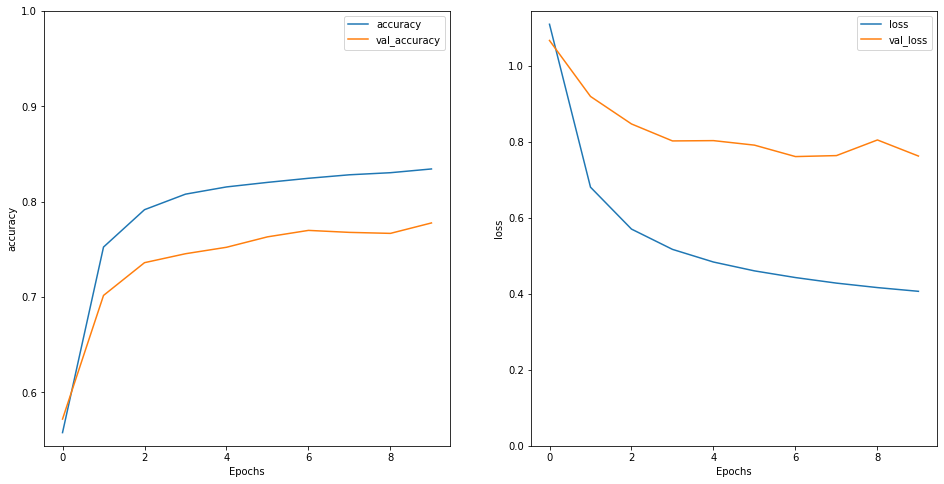

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
model.predict(["I'd like to know where I can eat something nice."])

array([[9.6136361e-01, 7.9733217e-03, 5.4176711e-04, 3.0121349e-02]],
      dtype=float32)

In [ ]:
model.predict(["I'd like to buy a plane ticket to Recife"])

array([[7.6768547e-04, 1.6219402e-02, 1.7212238e-04, 9.8284078e-01]],
      dtype=float32)